In [58]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, make_scorer, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, validation_curve

In [59]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sreechandanakurella/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [60]:
df = pd.read_csv('data.csv', encoding='latin1')
df.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative,noon,60-70,Angola,32866272,1246700.0,26


In [61]:
df = df[['text', 'sentiment', 'Country']]
df.dropna(inplace=True)
df.head()

,text,sentiment,Country
0,"I`d have responded, if I were going",neutral,Afghanistan
1,Sooo SAD I will miss you here in San Diego!!!,negative,Albania
2,my boss is bullying me...,negative,Algeria
3,what interview! leave me alone,negative,Andorra
4,"Sons of ****, why couldn`t they put them on t...",negative,Angola


In [62]:
df['sentiment'] = df['sentiment'].replace({'positive': 2, 'neutral': 1, 'negative': 0})
df.head()

,text,sentiment,Country
0,"I`d have responded, if I were going",1,Afghanistan
1,Sooo SAD I will miss you here in San Diego!!!,0,Albania
2,my boss is bullying me...,0,Algeria
3,what interview! leave me alone,0,Andorra
4,"Sons of ****, why couldn`t they put them on t...",0,Angola


In [63]:
# Create a SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
# Apply VADER sentiment analysis to each row in the DataFrame
df['vader_score'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Map the VADER compound score to sentiment labels
df['vader_sentiment'] = df['vader_score'].apply(lambda x: 2 if x >= 0.05 else (0 if x <= -0.05 else 1))

# Display the DataFrame with VADER sentiment scores
df.head()

,text,sentiment,Country,vader_score,vader_sentiment
0,"I`d have responded, if I were going",1,Afghanistan,0.0000,1
1,Sooo SAD I will miss you here in San Diego!!!,0,Albania,-0.7437,0
2,my boss is bullying me...,0,Algeria,-0.5994,0
3,what interview! leave me alone,0,Andorra,-0.3595,0
4,"Sons of ****, why couldn`t they put them on t...",0,Angola,0.0000,1


In [64]:
acc = accuracy_score(df['sentiment'],df['vader_sentiment'])
print(f'Accuracy: {acc:.2f}')

Accuracy: 0.63


In [65]:
def text_cleaning(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Removing mentions
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)  # Removing URLs
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Removing non-alphabetic characters
    text = ' '.join([word for word in text.split() if word.lower() not in stopwords.words('english') and word.lower() not in ENGLISH_STOP_WORDS])
    return text.lower()
df['text'] = df['text'].apply(text_cleaning)
df.head()

,text,sentiment,Country,vader_score,vader_sentiment
0,responded going,1,Afghanistan,0.0000,1
1,sooo sad miss san diego,0,Albania,-0.7437,0
2,boss bullying,0,Algeria,-0.5994,0
3,interview leave,0,Andorra,-0.3595,0
4,sons releases bought,0,Angola,0.0000,1


In [66]:
# Split the dataset
X_train, X_test, y_train, y_test, country_train, country_test = train_test_split(
    df['text'], df['sentiment'], df['Country'], test_size=0.2, random_state=42
)

In [67]:
# Feature extraction using TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [68]:
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    
    print(f"{model_name} Evaluation Metrics:")
    print(f'Overall Accuracy: {accuracy:.2f}')
    print('\nOverall Classification Report:')
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

In [69]:
# Naive Bayes Classifier
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tfidf , y_train)
nb_pred = nb_clf.predict(X_test_tfidf)

In [70]:
# Logistic Regression
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train_tfidf , y_train)
lr_pred = lr_clf.predict(X_test_tfidf)

In [71]:
# Decision Tree
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train_tfidf , y_train)
dt_pred = dt_clf.predict(X_test_tfidf)

In [72]:
# Train a Support Vector Machine (SVM) classifier
svm = SVC(kernel='linear')
svm.fit(X_train_tfidf, y_train)

# Make predictions on the test set
svm_pred = svm.predict(X_test_tfidf)

In [73]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)

rf_pred = rf.predict(X_test_tfidf)

In [74]:
evaluate_model(y_test, nb_pred ,"Naive Bayes")

Naive Bayes Evaluation Metrics:
Overall Accuracy: 0.63

Overall Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.48      0.58      1749
           1       0.55      0.76      0.64      2502
           2       0.72      0.59      0.65      1952

    accuracy                           0.63      6203
   macro avg       0.67      0.61      0.62      6203
weighted avg       0.66      0.63      0.63      6203

Confusion Matrix:
[[ 838  823   88]
 [ 248 1898  356]
 [  55  739 1158]]


In [75]:
evaluate_model(y_test, lr_pred ,"Logistic Regression")

Logistic Regression Evaluation Metrics:
Overall Accuracy: 0.69

Overall Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.57      0.64      1749
           1       0.62      0.76      0.68      2502
           2       0.78      0.70      0.74      1952

    accuracy                           0.69      6203
   macro avg       0.71      0.68      0.69      6203
weighted avg       0.70      0.69      0.69      6203

Confusion Matrix:
[[ 998  651  100]
 [ 318 1891  293]
 [  59  524 1369]]


In [76]:
evaluate_model(y_test, dt_pred ,"Decision Tree")

Decision Tree Evaluation Metrics:
Overall Accuracy: 0.65

Overall Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.61      0.62      1749
           1       0.63      0.63      0.63      2502
           2       0.69      0.70      0.69      1952

    accuracy                           0.65      6203
   macro avg       0.65      0.65      0.65      6203
weighted avg       0.65      0.65      0.65      6203

Confusion Matrix:
[[1062  523  164]
 [ 464 1578  460]
 [ 158  423 1371]]


In [77]:
evaluate_model(y_test, svm_pred ,"Support vector machine")

Support vector machine Evaluation Metrics:
Overall Accuracy: 0.71

Overall Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.59      0.66      1749
           1       0.64      0.77      0.70      2502
           2       0.79      0.73      0.76      1952

    accuracy                           0.71      6203
   macro avg       0.73      0.70      0.71      6203
weighted avg       0.72      0.71      0.71      6203

Confusion Matrix:
[[1032  626   91]
 [ 282 1936  284]
 [  59  472 1421]]


In [78]:
evaluate_model(y_test, rf_pred ,"Random Forest")

Random Forest Evaluation Metrics:
Overall Accuracy: 0.70

Overall Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.61      0.66      1749
           1       0.66      0.71      0.68      2502
           2       0.73      0.77      0.75      1952

    accuracy                           0.70      6203
   macro avg       0.70      0.70      0.70      6203
weighted avg       0.70      0.70      0.70      6203

Confusion Matrix:
[[1061  549  139]
 [ 326 1764  412]
 [  86  355 1511]]


In [79]:
evaluate_model(df['sentiment'],df['vader_sentiment'],"vader")

vader Evaluation Metrics:
Overall Accuracy: 0.63

Overall Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.60      0.65      8782
           1       0.71      0.47      0.57     12547
           2       0.56      0.87      0.68      9685

    accuracy                           0.63     31014
   macro avg       0.66      0.65      0.63     31014
weighted avg       0.66      0.63      0.62     31014

Confusion Matrix:
[[5269 1600 1913]
 [1879 5933 4735]
 [ 386  864 8435]]


In [80]:
# Confusion Matrix for Naive Bayes
cm_nb = confusion_matrix(y_test, nb_pred)

# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, lr_pred)

# Confusion Matrix for Decision Tree
cm_dt = confusion_matrix(y_test, dt_pred)

# Confusion Matrix for Support Vector Machine
cm_svm = confusion_matrix(y_test, svm_pred)

# Confusion Matrix for Random Forest Classifier
cm_rf = confusion_matrix(y_test, rf_pred)

# Confusion Matrix for VADER
cm_vd = confusion_matrix(df['sentiment'],df['vader_sentiment'])

Text(0.5, 1.0, 'Naive Bayes Confusion Matrix')

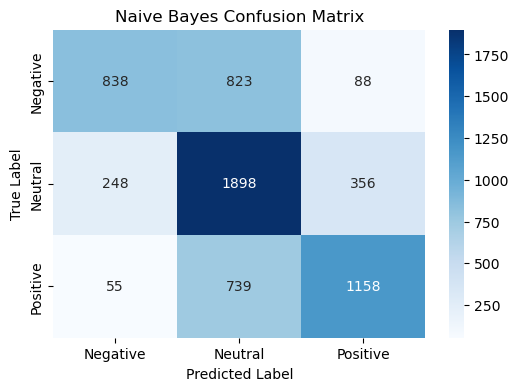

In [81]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Neutral','Positive'], yticklabels=['Negative','Neutral','Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Naive Bayes Confusion Matrix')

Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

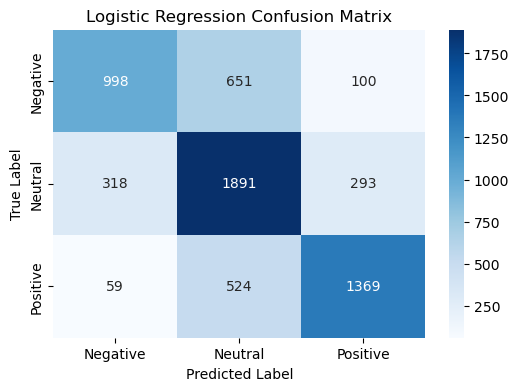

In [82]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Neutral','Positive'], yticklabels=['Negative','Neutral','Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression Confusion Matrix')

Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

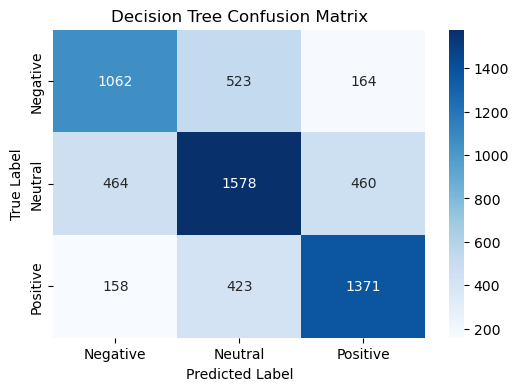

In [83]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Neutral','Positive'], yticklabels=['Negative','Neutral','Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Decision Tree Confusion Matrix')

Text(0.5, 1.0, 'Support Vector Machine Confusion Matrix')

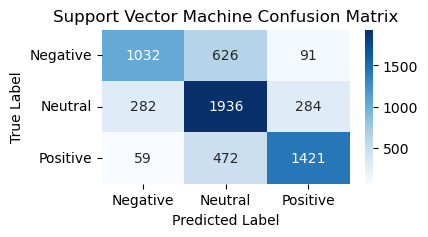

In [93]:
plt.figure(figsize=(4, 2))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Neutral','Positive'], yticklabels=['Negative','Neutral','Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Support Vector Machine Confusion Matrix')

Text(0.5, 1.0, 'Random Forest Confusion Matrix')

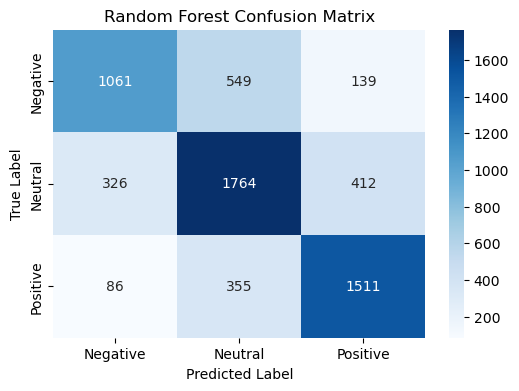

In [85]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Neutral','Positive'], yticklabels=['Negative','Neutral','Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')

Text(0.5, 1.0, 'Vader Confusion Matrix')

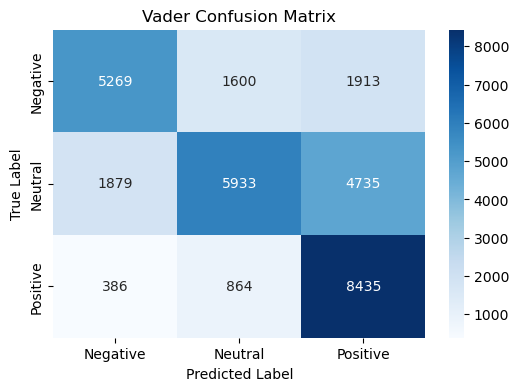

In [86]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm_vd, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Neutral','Positive'], yticklabels=['Negative','Neutral','Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Vader Confusion Matrix')

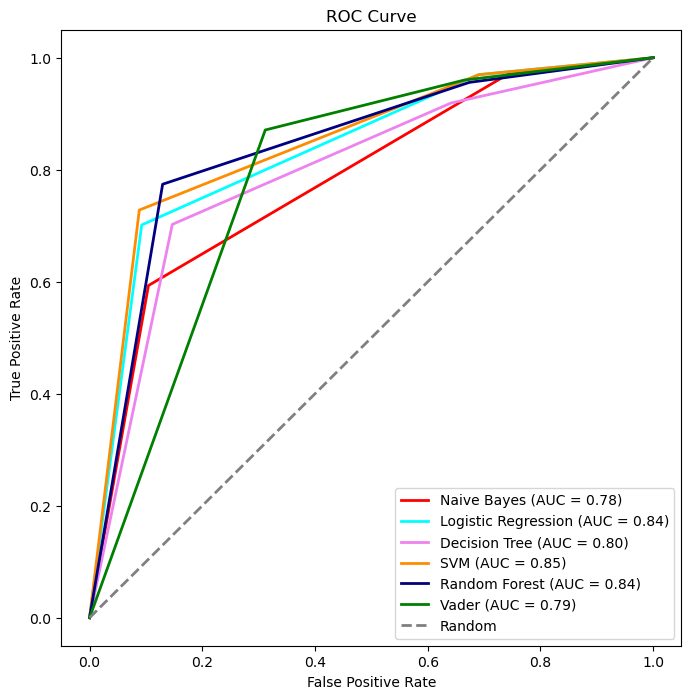

In [87]:
# ROC Curve for Naive Bayes
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_pred , pos_label= 2)
roc_auc_nb = auc(fpr_nb, tpr_nb)

# ROC Curve for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_pred, pos_label= 2)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# ROC Curve for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_pred, pos_label= 2)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# ROC Curve for SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_pred , pos_label= 2)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# ROC Curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred, pos_label= 2)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# ROC Curve for Vader
fpr_vd, tpr_vd, _ = roc_curve(df['sentiment'],df['vader_sentiment'], pos_label= 2)
roc_auc_vd = auc(fpr_vd, tpr_vd)

# Plot ROC Curves
plt.figure(figsize=(8,8))
plt.plot(fpr_nb, tpr_nb, color='red', lw=2, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
plt.plot(fpr_lr, tpr_lr, color='cyan', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_dt, tpr_dt, color='violet', lw=2, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})') 
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_rf, tpr_rf, color='navy', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_vd, tpr_vd, color='green', lw=2, label=f'Vader (AUC = {roc_auc_vd:.2f})') 
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

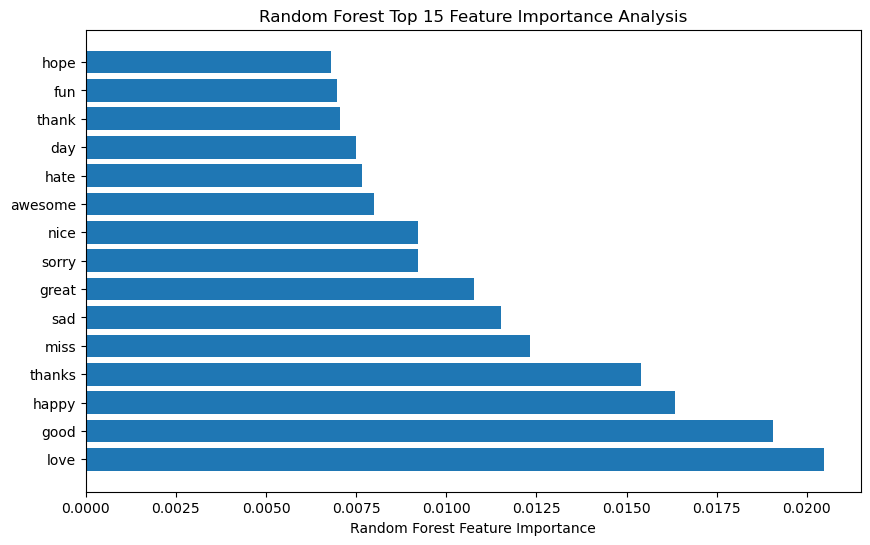

/var/folders/gx/l9lsx5qn4yvgkddyh12mxt9h0000gn/T/ipykernel_53217/3875203849.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(probas[:, i], hist=False, kde_kws={"label": f"{model_name} - Class {class_label}"})
/var/folders/gx/l9lsx5qn4yvgkddyh12mxt9h0000gn/T/ipykernel_53217/3875203849.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.gith

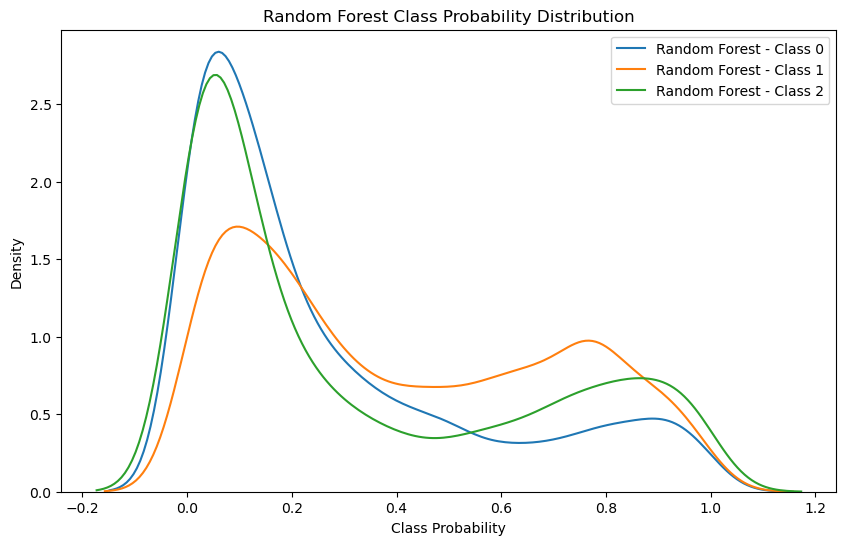

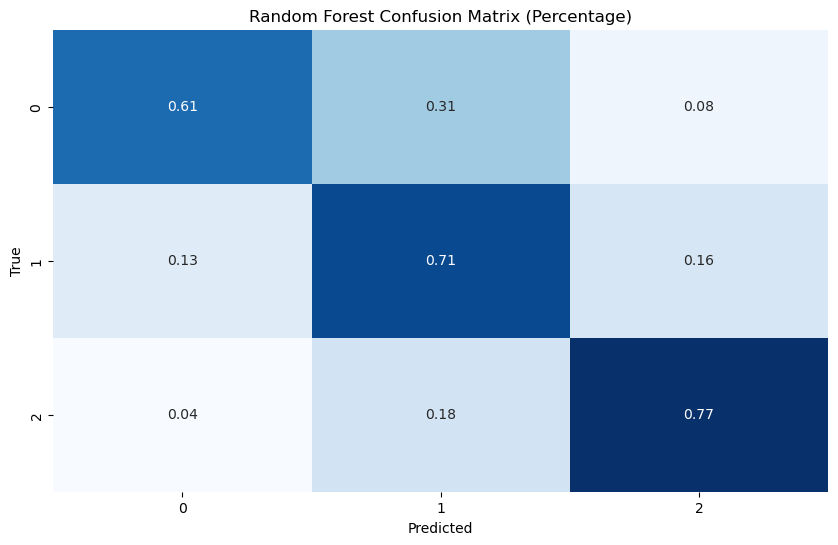

In [88]:
def plot_top_feature_importance(model, feature_names, top_n, model_name):
    if hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
        sorted_idx = feature_importance.argsort()[::-1][:top_n]
        features = [feature_names[i] for i in sorted_idx]
        importance = feature_importance[sorted_idx]

        plt.figure(figsize=(10, 6))
        plt.barh(range(len(importance)), importance, align="center")
        plt.yticks(range(len(importance)), features)
        plt.xlabel(f"{model_name} Feature Importance")
        plt.title(f"{model_name} Top {top_n} Feature Importance Analysis")
        plt.show()

# Class Probability Distribution
def plot_class_probability_distribution(model, X, y, model_name):
    probas = model.predict_proba(X)
    unique_classes = model.classes_

    plt.figure(figsize=(10, 6))
    for i, class_label in enumerate(unique_classes):
        sns.distplot(probas[:, i], hist=False, kde_kws={"label": f"{model_name} - Class {class_label}"})

    plt.xlabel("Class Probability")
    plt.ylabel("Density")
    plt.title(f"{model_name} Class Probability Distribution")
    plt.legend()
    plt.show()

# Error Analysis - Confusion Matrix Heatmap
def plot_confusion_matrix_heatmap(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 6))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix (Percentage)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# ... (Your previous code)

# Plot Feature Importance for Random Forest
top_n_features = 15  
plot_top_feature_importance(rf, vectorizer.get_feature_names_out(), top_n_features, 'Random Forest')

# Plot Class Probability Distribution
plot_class_probability_distribution(rf, X_test_tfidf, y_test, 'Random Forest')

# Plot Error Analysis
plot_confusion_matrix_heatmap(y_test, rf_pred, 'Random Forest')


In [89]:
def perform_cross_validation(model, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')  
    return scores

nb_cv_scores = perform_cross_validation(nb_clf, X_train_tfidf, y_train)

lr_cv_scores = perform_cross_validation(lr_clf, X_train_tfidf, y_train)

dt_cv_scores = perform_cross_validation(dt_clf, X_train_tfidf, y_train)
svm_scores = perform_cross_validation(svm, X_train_tfidf, y_train)
rf_scores = perform_cross_validation(rf, X_train_tfidf, y_train)

print(f'Naive Bayes Cross-Validation Scores: {nb_cv_scores}')
print(f'Logistic Regression Cross-Validation Scores: {lr_cv_scores}')
print(f'Decision Tree Cross-Validation Scores: {dt_cv_scores}')
print("SVM Cross-Validation Scores:", svm_scores)
print("Random Forest Cross-Validation Scores:", rf_scores)

Naive Bayes Cross-Validation Scores: [0.6449728  0.64006449 0.63180169 0.63200322 0.6388553 ]
Logistic Regression Cross-Validation Scores: [0.69272617 0.68419992 0.68097541 0.67271262 0.68621524]
Decision Tree Cross-Validation Scores: [0.64416683 0.66324063 0.64590891 0.64792422 0.65235792]
SVM Cross-Validation Scores: [0.70320371 0.69548569 0.68943974 0.69407497 0.69568722]
Random Forest Cross-Validation Scores: [0.70018134 0.69729948 0.6904474  0.69770254 0.69790407]


/Users/sreechandanakurella/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sreechandanakurella/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

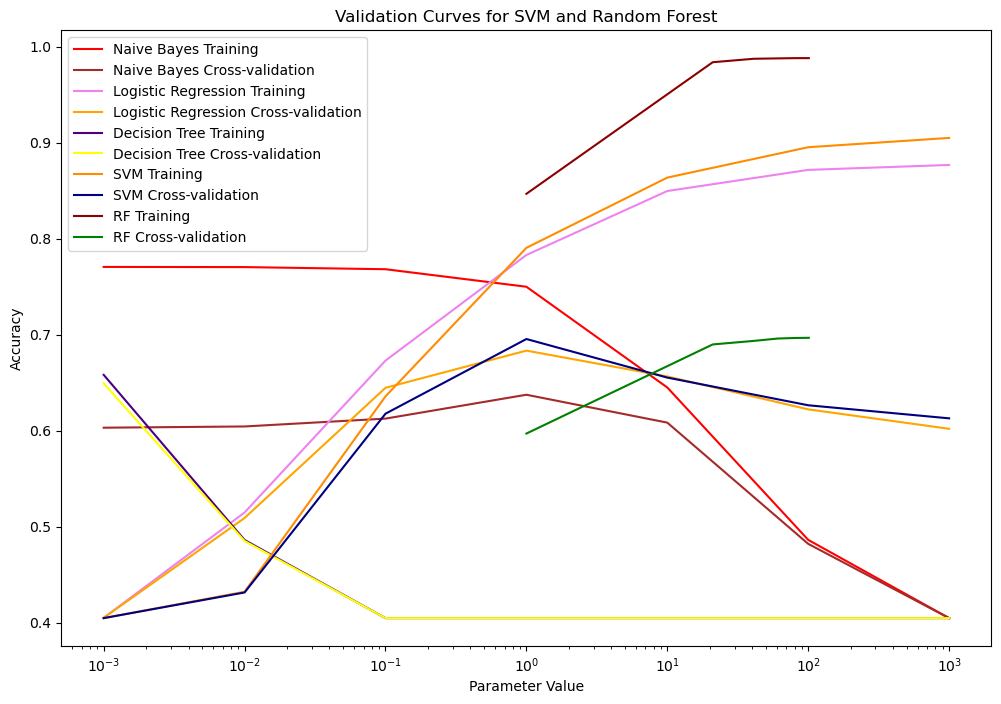

In [90]:
# Vary the 'C' parameter for SVM
param_range = np.logspace(-3, 3, 7)

# Plot validation curves for SVM and Random Forest
plt.figure(figsize=(12, 8))

# Validation curve for Naive Bayes
train_scores_nb, test_scores_nb = validation_curve(
    nb_clf, X_train_tfidf, y_train, param_name="alpha", param_range=param_range,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="accuracy", n_jobs=-1
)

train_scores_nb_mean = np.mean(train_scores_nb, axis=1)
test_scores_nb_mean = np.mean(test_scores_nb, axis=1)

plt.semilogx(param_range, train_scores_nb_mean, label="Naive Bayes Training", color="Red")
plt.semilogx(param_range, test_scores_nb_mean, label="Naive Bayes Cross-validation", color="Brown")

# Validation curve for Logistic Regression
train_scores_lr, test_scores_lr = validation_curve(
    lr_clf, X_train_tfidf, y_train, param_name="C", param_range=param_range,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="accuracy", n_jobs=-1
)

train_scores_lr_mean = np.mean(train_scores_lr, axis=1)
test_scores_lr_mean = np.mean(test_scores_lr, axis=1)

plt.semilogx(param_range, train_scores_lr_mean, label="Logistic Regression Training", color="Violet")
plt.semilogx(param_range, test_scores_lr_mean, label="Logistic Regression Cross-validation", color="orange")

# Validation curve for Decision Tree
train_scores_dt, test_scores_dt = validation_curve(
    dt_clf, X_train_tfidf, y_train, param_name="ccp_alpha", param_range=param_range,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="accuracy", n_jobs=-1
)

train_scores_dt_mean = np.mean(train_scores_dt, axis=1)
test_scores_dt_mean = np.mean(test_scores_dt, axis=1)

plt.semilogx(param_range, train_scores_dt_mean, label="Decision Tree Training", color="indigo")
plt.semilogx(param_range, test_scores_dt_mean, label="Decision Tree Cross-validation", color="yellow")

# Validation curve for SVM
train_scores_svm, test_scores_svm = validation_curve(
    svm, X_train_tfidf, y_train, param_name="C", param_range=param_range,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="accuracy", n_jobs=-1
)

train_scores_svm_mean = np.mean(train_scores_svm, axis=1)
test_scores_svm_mean = np.mean(test_scores_svm, axis=1)

plt.semilogx(param_range, train_scores_svm_mean, label="SVM Training", color="darkorange")
plt.semilogx(param_range, test_scores_svm_mean, label="SVM Cross-validation", color="navy")

# Validation curve for Random Forest
train_scores_rf, test_scores_rf = validation_curve(
    rf, X_train_tfidf, y_train, param_name="n_estimators", param_range=np.arange(1, 102, 20),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="accuracy", n_jobs=-1
)

train_scores_rf_mean = np.mean(train_scores_rf, axis=1)
test_scores_rf_mean = np.mean(test_scores_rf, axis=1)

plt.semilogx(np.arange(1, 102, 20), train_scores_rf_mean, label="RF Training", color="darkred")
plt.semilogx(np.arange(1, 102, 20), test_scores_rf_mean, label="RF Cross-validation", color="green")

plt.title("Validation Curves for SVM and Random Forest")
plt.xlabel("Parameter Value")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()



In [96]:
# User interaction
while True:
    user_input = input("Enter a statement (type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        print("Exiting the program. Goodbye!")
        break

    # Vectorize the user input
    user_input_tfidf = vectorizer.transform([user_input])

    # Predict sentiment for the user input
    rf_sentiment = rf.predict(user_input_tfidf)[0]
    lr_sentiment = lr_clf.predict(user_input_tfidf)[0]
    svm_sentiment = svm.predict(user_input_tfidf)[0]
    nb_sentiment = nb_clf.predict(user_input_tfidf)[0]
    # Map numerical values to sentiment labels
    sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    
    rf_label = sentiment_labels.get(rf_sentiment, 'Unknown')
    lr_label = sentiment_labels.get(lr_sentiment, 'Unknown')
    svm_label = sentiment_labels.get(svm_sentiment, 'Unknown')
    nb_label = sentiment_labels.get(nb_sentiment, 'Unknown')

    print(f"The sentiment of the statement '{user_input}' is {rf_label} by Random Forest")
    print(f"The sentiment of the statement '{user_input}' is {lr_label} by Logistic Regression")
    print(f"The sentiment of the statement '{user_input}' is {svm_label} by Support Vector Machine")
    print(f"The sentiment of the statement '{user_input}' is {nb_label} by Naive Bayes")


Enter a statement (type 'exit' to quit): Thilok is Presenting very vey well 
The sentiment of the statement 'Thilok is Presenting very vey well ' is Neutral by Random Forest
The sentiment of the statement 'Thilok is Presenting very vey well ' is Neutral by Logistic Regression
The sentiment of the statement 'Thilok is Presenting very vey well ' is Neutral by Support Vector Machine
The sentiment of the statement 'Thilok is Presenting very vey well ' is Neutral by Naive Bayes
Enter a statement (type 'exit' to quit): Today is a good day 
The sentiment of the statement 'Today is a good day ' is Positive by Random Forest
The sentiment of the statement 'Today is a good day ' is Positive by Logistic Regression
The sentiment of the statement 'Today is a good day ' is Positive by Support Vector Machine
The sentiment of the statement 'Today is a good day ' is Positive by Naive Bayes
Enter a statement (type 'exit' to quit): I hate that  I love the movie @ Animal
The sentiment of the statement 'I h